## Health Care Analysis Kerdo Index - Machine Learning Pipeline

### 1) Data Load

In [44]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# read dataset
dataset = pd.read_excel("../subsets/data_index_Kerdo.xlsx")
dataset.head()

,x18,x29,x11,x40,x19,x7,x27,x42,x44,x20,Kerdo
0,0.257528,0.129041,-0.102024,0.342039,0.451712,-0.635477,-0.174973,0.652350,0.421695,-0.493977,18.9
1,-0.333339,0.787807,-0.102024,0.313666,0.606736,0.693801,-0.408477,0.405378,-0.610442,-0.612668,-2.9
2,0.445832,0.788520,0.372670,-0.285098,-0.571101,0.277291,-0.408205,0.658857,0.574346,-0.164593,-6.1
3,-0.562948,0.115385,-0.165667,-0.572834,0.275787,-0.031358,-0.408100,-0.645115,-0.338480,0.646413,3.2
4,-0.570520,-0.304600,-0.419677,0.681048,0.449087,-0.630210,0.722157,0.434044,0.173512,-0.489180,-20.7


### 2) Statistical Data Analysis (EDA)

In [46]:
def hist_frequencies(data, bins):
    # calculate the nrows and ncols for plots
    numeric_cols = data.columns
    ncol_plots = 3
    nrow_plots = (len(numeric_cols) + ncol_plots - 1) // ncol_plots
    # create the subplots for specific row and column
    fig, axs = plt.subplots(nrow_plots, ncol_plots, figsize = (16, 4 * nrow_plots))
    axs = axs.flatten()    
    
    for i, col in enumerate(numeric_cols):
        sns.histplot(data[col], color = "blue", bins = bins, ax = axs[i])
        axs[i].set_title("Histogram of frequencies for " + col)
        plt.xlabel(col)
        plt.ylabel("Frequencies")
    plt.tight_layout()
    plt.show()

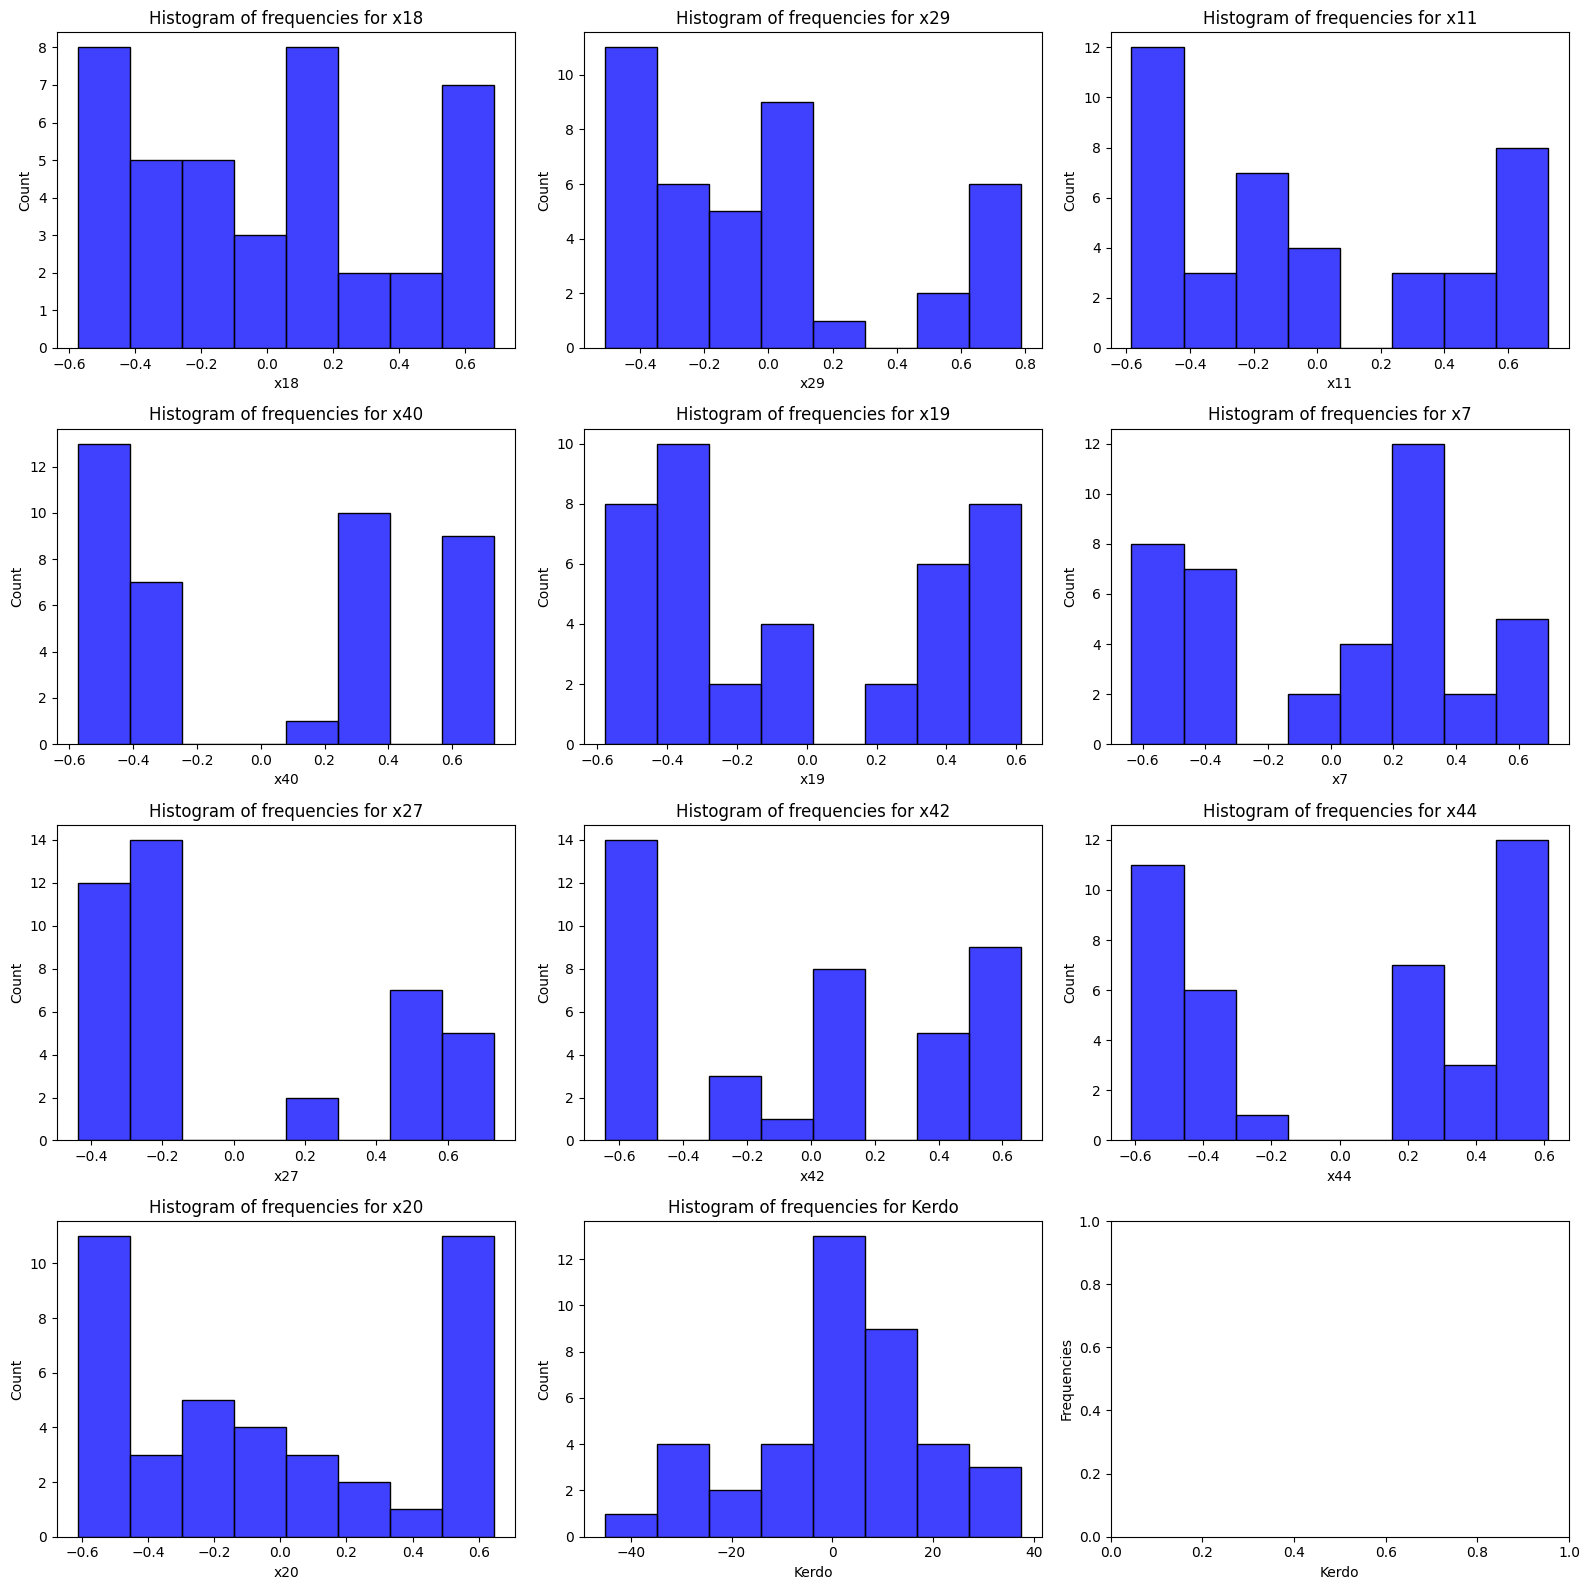

In [47]:
hist_frequencies(dataset, bins = 8)

### 3) Preprocessing

In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
import torch
from torch.utils.data import DataLoader, TensorDataset

In [49]:
x = dataset.loc[:, dataset.columns!= "Kerdo"]
y = dataset["Kerdo"].values

### 4) Build Model Architecture

In [50]:
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn as nn
import torch.optim as optim

In [51]:
# pytorch class to define regressor architecture
class RegressionNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_func):
        super(RegressionNeuralNet, self).__init__()
        layers = []
        layer_sizes = [input_size] + hidden_layers
        self.activation_dict = {
            "relu": nn.ReLU(),
            "sigmoid": nn.Sigmoid(),
            "tanh": nn.Tanh()
        }

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(in_features=layer_sizes[i], out_features=layer_sizes[i+1])) #linear comb
            layers.append(self.activation_dict[activation_func])    # activation function
        layers.append(nn.Linear(in_features=layer_sizes[-1], out_features=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [52]:
# define list of experiments
experiments = [
    {'hidden_layers': [8, 4, 2], 'activation': 'relu'},
    {'hidden_layers': [8, 4], 'activation': 'relu'},
    {'hidden_layers': [8, 4, 2], 'activation': 'sigmoid'},
    {'hidden_layers': [8, 4], 'activation': 'sigmoid'},
    {'hidden_layers': [8, 4, 2], 'activation': 'tanh'},
    {'hidden_layers': [8, 4], 'activation': 'tanh'},
]

### 5) Training / Validation

In [53]:
import os

In [54]:
# Define the training function
def train_model(model, train_dataset, test_dataset, num_epochs=1000, patience=200):
    criterion = nn.MSELoss()    #loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    train_losses = []
    test_losses = []
    train_rmse = []
    train_r2 = []
    val_rmse = []
    val_r2 = []

    x_train, y_train = train_dataset.tensors
    x_test, y_test = test_dataset.tensors
    print(f"Train input shape: {x_train.shape}, Test input shape: {x_test.shape}")

    best_loss = float('inf')
    best_model_state = None

    os.makedirs("models", exist_ok = True)
    model_path = os.path.join("models", "best_model.pth")

    # for each iteration
    for epoch in range(num_epochs):
        # training
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # validation
        model.eval()
        with torch.no_grad():
            # eval metrics in training process
            train_outputs = model(x_train)
            y_pred_train = train_outputs.numpy()
            y_true_train = y_train.numpy()
            train_rmse.append(np.sqrt(mean_squared_error(y_true_train, y_pred_train)))
            train_r2.append(r2_score(y_true_train, y_pred_train))      

            # eval metrics in validation process
            outputs = model(x_test)
            loss = criterion(outputs, y_test)
            test_losses.append(loss.item())

            # calulate validation metrics
            y_true_val = y_test.numpy()
            y_pred_val = outputs.numpy()
            val_rmse.append(np.sqrt(mean_squared_error(y_true_val, y_pred_val)))
            val_r2.append(r2_score(y_true_val, y_pred_val))
        
        # Early stopping
        if test_losses[-1] < best_loss:
            best_loss = test_losses[-1]
            patience_counter = 0
            best_model_state = model.state_dict()
            torch.save(best_model_state, model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break
        
    return train_losses, test_losses, train_rmse, train_r2, val_rmse, val_r2

In [55]:
def run_training_cv(input_size, experiments, x, y, n_splits=5):

    # define the k-folds for cross-validation process
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    experiment_results = []

    # Convert DataFrames to NumPy arrays if necessary
    if isinstance(x, pd.DataFrame):
        x = x.values
    if isinstance(y, pd.DataFrame):
        y = y.values
    

    for experiment in experiments:
        print(f"Run experiment with hidden layers: {experiment['hidden_layers']}, activation: {experiment['activation']}")
        fold_results = []
        train_rmse_folds = []
        train_r2_folds = []
        test_rmse_folds = []
        test_r2_folds = []

        for fold, (train_idx, test_idx) in enumerate(kf.split(x)):
            print(f"Fold {fold+1}")            
            
            # split the train and test data
            x_train, x_test = x[train_idx], y[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
            
            # Standardize the data
            """
            transformer = StandardScaler()
            transformer.fit(x_train)
            x_train = transformer.transform(x_train)
            x_test = transformer.transform(x_test)
            """

            # convert to tensors
            x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
            x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
            y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

            # create the dataloaders
            train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
            test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
            
            # initialize the model
            model = RegressionNeuralNet(input_size=input_size,
                                        hidden_layers=experiment['hidden_layers'],
                                        activation_func=experiment['activation'])
            
            train_losses, test_losses, train_rmse, train_r2, val_rmse, val_r2 = \
                                        train_model(model, train_dataset, test_dataset)

            # calculate the testing metrics
            model.eval()
            with torch.no_grad():
                y_pred = model(x_test_tensor)
        
            # calculate metrics for model quality
            y_pred_test = y_pred.numpy()
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            test_r2 = r2_score(y_test, y_pred_test)
            print(f"Fold {fold+1} ===> Test RMSE: {test_rmse:.4f}, Test R^2: {test_r2:.4f}")            

            fold_results.append({
                'fold': fold+1,
                'train_losses': train_losses,
                'test_losses': test_losses,
                'train_rmse': train_rmse,
                'train_r2': train_r2,
                'val_rmse': val_rmse,
                'val_r2': val_r2,
                'test_rmse': test_rmse,
                'test_r2': test_r2
            })

            train_rmse_folds.append(min(train_rmse))
            train_r2_folds.append(max(train_r2))
            test_rmse_folds.append(test_rmse)
            test_r2_folds.append(test_r2)

        mean_train_rmse = np.mean(train_rmse_folds)
        mean_train_r2 = np.mean(train_r2_folds)

        print(f"Mean Train RMSE: {mean_train_rmse:.4f}, Mean Train R^2: {mean_train_r2:.4f}")

        experiment_results.append({
            'experiment': experiment, 
            'fold_results': fold_results,
            'mean_train_rmse': mean_train_rmse,
            'mean_train_r2': mean_train_r2,
            'test_rmse_folds': test_rmse_folds,
            'test_r2_folds': test_r2_folds
        })

    return experiment_results

In [56]:
# run the training/test process
exp_results = run_training_cv(x.shape[1], experiments, x, y)

Run experiment with hidden layers: [8, 4, 2], activation: relu
Fold 1
x_train shape: (32, 10), x_test shape: (8,), y_train shape: (32,), y_test shape: (8,)
Train input shape: torch.Size([32, 10]), Test input shape: torch.Size([8])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x8 and 10x8)

### 6) Monitoring Results

In [ ]:
def monitoring_results(experiment_results):

    # Plotting the results
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))

    experiment_labels = [f"{result['experiment']['hidden_layers']} layers, {result['experiment']['activation']}" 
                            for result in experiment_results]

    # Plot train and test loss by epoch for each experiment    
    mean_train_rmses = [result['mean_train_rmse'] for result in experiment_results]
    mean_test_rmses = [np.mean(result['test_rmse_folds']) for result in experiment_results]
    x = np.arange(len(experiment_labels))
    width = 0.35

    bars_train_rmse = axes[0].bar(x - width/2, mean_train_rmses, width, label='Mean Train RMSE')
    bars_test_rmse = axes[0].bar(x + width/2, mean_test_rmses, width, label='Mean Test RMSE')
    axes[0].set_title('Mean RMSE by Experiment (5-Fold CV)')
    axes[0].set_xlabel('Experiment')
    axes[0].set_ylabel('RMSE')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(experiment_labels, rotation=45, ha='right')
    axes[0].legend()
    axes[0].set_ylim(0, max(max(mean_train_rmses), max(mean_test_rmses)) * 1.1)

    # Annotate RMSE bars
    for bars in [bars_train_rmse, bars_test_rmse]:
        for bar in bars:
            yval = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom')

    # Plot mean train and test R²
    mean_train_r2s = [result['mean_train_r2'] for result in experiment_results]
    mean_test_r2s = [np.mean(result['test_r2_folds']) for result in experiment_results]
    bars_train_r2 = axes[1].bar(x - width/2, mean_train_r2s, width, label='Mean Train R²')
    bars_test_r2 = axes[1].bar(x + width/2, mean_test_r2s, width, label='Mean Test R²')
    axes[1].set_title('Mean R² by Experiment (5-Fold CV)')
    axes[1].set_xlabel('Experiment')
    axes[1].set_ylabel('R²')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(experiment_labels, rotation=45, ha='right')
    axes[1].legend()
    axes[1].set_ylim(0, 1)

    # Annotate R² bars
    for bars in [bars_train_r2, bars_test_r2]:
        for bar in bars:
            yval = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('cv_metrics_kerdo.png')
    plt.close()

    # Plot test RMSE and R² for each fold
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    for result in experiment_results:
        experiment = result['experiment']
        label = f"{experiment['hidden_layers']} layers, {experiment['activation']}"
        folds = range(1, 6)
        axes[0].plot(folds, result['test_rmse_folds'], marker='o', label=f"Test RMSE: {label}")
        axes[1].plot(folds, result['test_r2_folds'], marker='o', label=f"Test R²: {label}")

    axes[0].set_title('Test RMSE by Fold for Each Experiment')
    axes[0].set_xlabel('Fold')
    axes[0].set_ylabel('RMSE')
    axes[0].legend()
    axes[0].set_xticks(range(1, 6))

    axes[1].set_title('Test R² by Fold for Each Experiment')
    axes[1].set_xlabel('Fold')
    axes[1].set_ylabel('R²')
    axes[1].legend()
    axes[1].set_xticks(range(1, 6))

    plt.tight_layout()
    plt.savefig('fold_metrics_kerdo.png')
    plt.show()
    plt.close()    

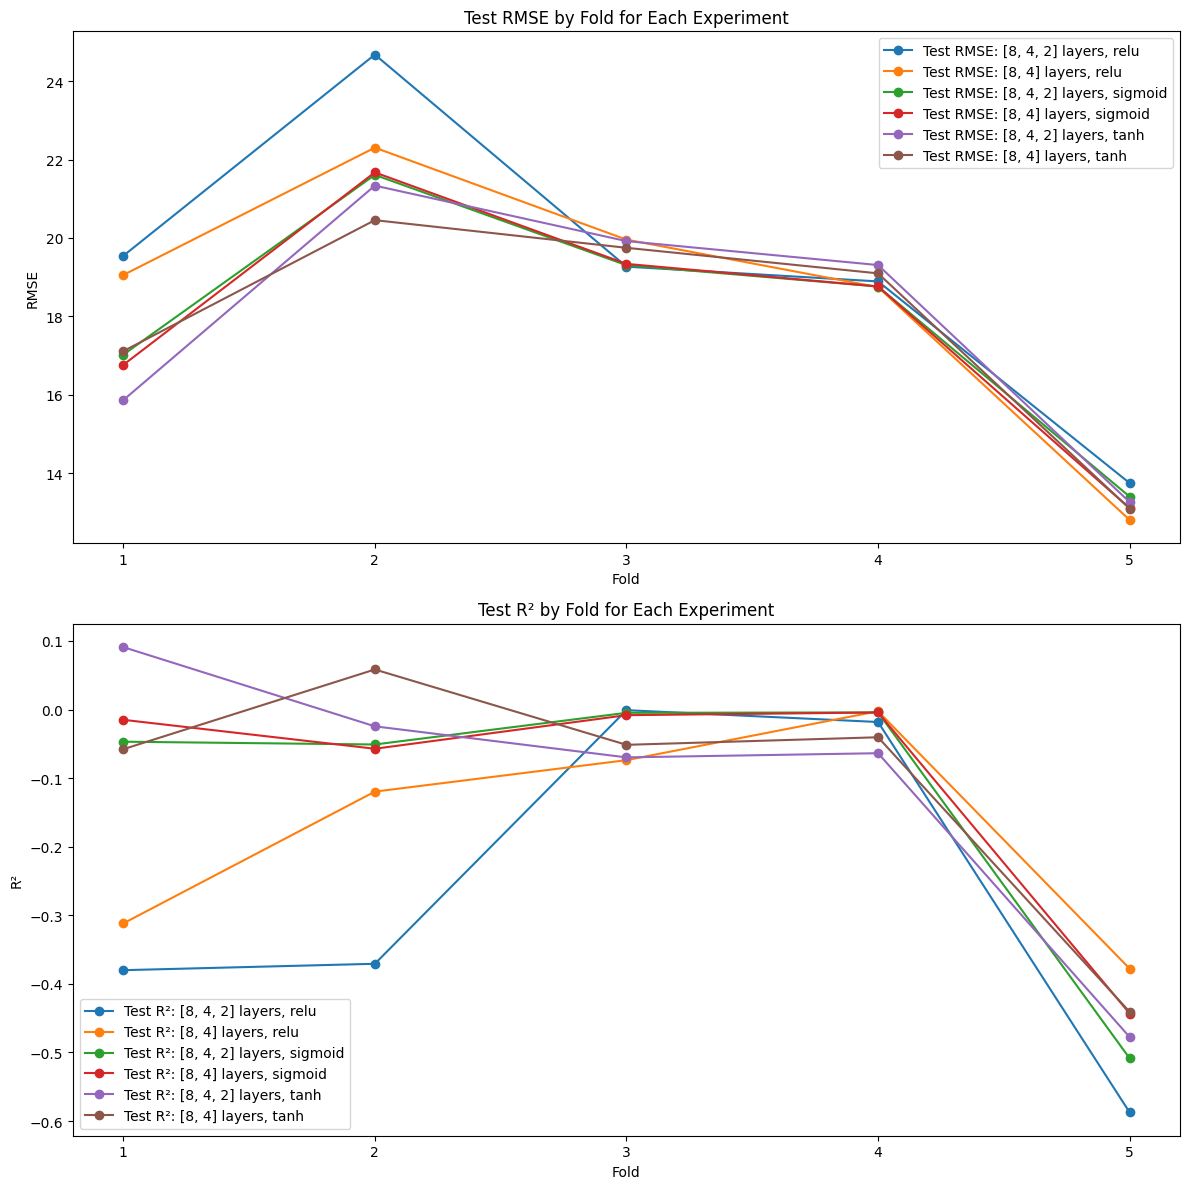

In [ ]:
monitoring_results(exp_results)

In [ ]:
def plot_results(experiment_results):
    # Extract data
    experiments = [res['experiment'] for res in experiment_results]
    mean_train_rmse = [res['mean_train_rmse'] for res in experiment_results]
    mean_train_r2 = [res['mean_train_r2'] for res in experiment_results]
    mean_test_rmse = [np.mean(res['test_rmse_folds']) for res in experiment_results]
    mean_test_r2 = [np.mean(res['test_r2_folds']) for res in experiment_results]

    # generate new labels
    x_labels = [f"experiment {i+1}" for i in range(len(experiments))]

    # Set up the bar plot
    x = np.arange(len(experiments))  # Label locations
    width = 0.2  # Width of the bars

    # Plot 1: Train and Test RMSE
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    bars_train_rmse = ax1.bar(x - width/2, mean_train_rmse, width, label='Mean Train RMSE', color='blue')
    bars_test_rmse = ax1.bar(x + width/2, mean_test_rmse, width, label='Mean Test RMSE', color='cyan')
    ax1.set_xlabel('Experiments')
    ax1.set_ylabel('RMSE')
    ax1.set_title('Mean Train and Test RMSE by Experiment')
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels, rotation=75)
    ax1.legend()

    # Add text annotations for RMSE
    for bar, value in zip(bars_train_rmse, mean_train_rmse):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.1f}', 
                 ha='center', va='bottom')
    for bar, value in zip(bars_test_rmse, mean_test_rmse):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.1f}', 
                 ha='center', va='bottom')
        
    plt.tight_layout()
    plt.savefig('results/rmse_plot_kerdo.png')

    # Plot 2: Train and Test R2
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    bars_train_r2 = ax2.bar(x - width/2, mean_train_r2, width, label='Mean Train R2', color='green')
    bars_test_r2 = ax2.bar(x + width/2, mean_test_r2, width, label='Mean Test R2', color='red')
    ax2.set_xlabel('Experiments')
    ax2.set_ylabel('R2')
    ax2.set_title('Mean Train and Test R2 by Experiment')
    ax2.set_xticks(x)
    ax2.set_xticklabels(x_labels, rotation=75)
    ax2.legend()

    # Add text annotations for R2
    for bar, value in zip(bars_train_r2, mean_train_r2):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.1f}', 
                 ha='center', va='bottom' if value >= 0 else 'top')
    for bar, value in zip(bars_test_r2, mean_test_r2):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.1f}', 
                 ha='center', va='bottom' if value >= 0 else 'top')

    # Adjust y-axis for negative R2 values
    min_r2 = min(min(mean_train_r2), min(mean_test_r2))
    ax2.set_ylim(min_r2 * 1.1 if min_r2 < 0 else -0.1, max(max(mean_train_r2), max(mean_test_r2)) * 1.1)
    
    plt.tight_layout()
    plt.savefig('results/r2_plot_kerdo.png')
    # Show plot
    plt.show()    

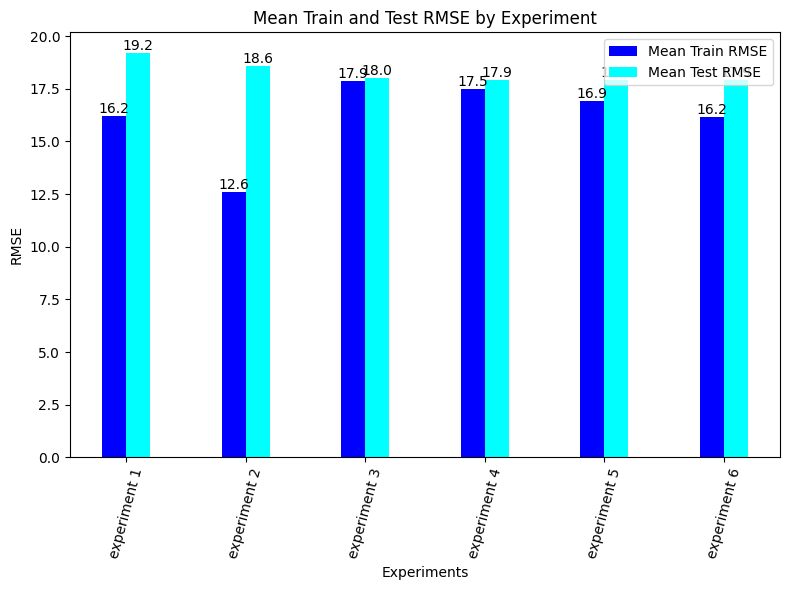

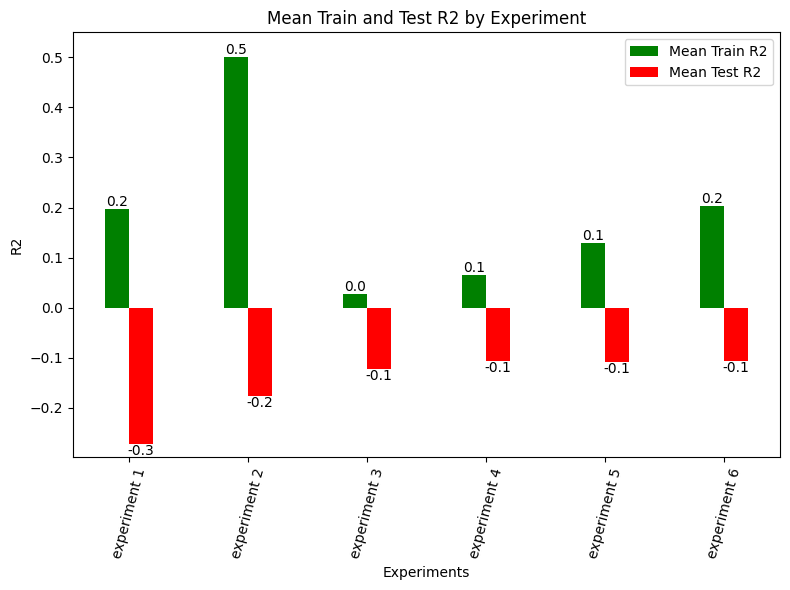

In [ ]:
plot_results(exp_results)